In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from utils import *
from models import *
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 500

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
d = 3
m = 8
t = 200
n = 100000
lamda = 0.2
distance = 0.1
coherent = False

array = ULA(m, lamda)
array.build_array(distance)
array.build_array_manifold()

loss_func_cpu = RMSPE(d, 'cpu')

In [ ]:
SNRs = [0, 5, 10, 15, 20]
methods = ["MUSIC", "Root-MUSIC", "DA-MUSIC", "DA-MUSIC v2", "RNN"]
mean_rmspe = {
    "MUSIC": [],
    "Root-MUSIC": [],
    "DA-MUSIC": [],
    "DA-MUSIC v2": [],
    "RNN": []
}
all_rmspe = {
    "MUSIC": [],
    "Root-MUSIC": [],
    "DA-MUSIC": [],
    "DA-MUSIC v2": [],
    "RNN": []
}

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array, False, coherent)

    # good_observations = []
    # good_angles = []
    # results_music = []
    # for i in range(observations.shape[0]):
    #     theta_est, _, good = MUSIC(observations[i].T, d, array)
    #     if good:
    #         good_observations.append(observations[i])
    #         good_angles.append(angles[i])
    #         results_music.append(theta_est)
    # observations = torch.stack(good_observations, dim=0)
    # angles = torch.stack(good_angles, dim=0)
    # results_music = torch.stack(results_music, dim=0)

    results_music = []
    for i in range(observations.shape[0]):
        theta_est, _, _ = MUSIC(observations[i].T, d, array)
        results_music.append(theta_est)
    results_music = torch.stack(results_music, dim=0)
    
    rmspe_music = loss_func_cpu.calculate(results_music, angles, average=False)
    all_rmspe['MUSIC'].append(rmspe_music)
    mean_rmspe['MUSIC'].append(torch.mean(rmspe_music))

    rmspe_root_music = loss_func_cpu.calculate(Root_MUSIC(observations, d, array), angles, average=False)
    all_rmspe['Root-MUSIC'].append(rmspe_root_music)
    mean_rmspe['Root-MUSIC'].append(torch.mean(rmspe_root_music))

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    da_music = DA_MUSIC(m, d, array, dev)
    mean_rmspe_da_music, all_rmspe_da_music = test(da_music, test_loader, path+'da_music_'+str(snr)+'dB.pth', dev)
    mean_rmspe['DA-MUSIC'].append(mean_rmspe_da_music.cpu())
    all_rmspe['DA-MUSIC'].append(all_rmspe_da_music.cpu())

    da_music_v2 = DA_MUSIC_v2(m, d, array, dev)
    mean_rmspe_da_music_v2, all_rmspe_da_music_v2 = test(da_music_v2, test_loader, path+'da_music_v2_'+str(snr)+'dB.pth', dev)
    mean_rmspe['DA-MUSIC v2'].append(mean_rmspe_da_music_v2.cpu())
    all_rmspe['DA-MUSIC v2'].append(all_rmspe_da_music_v2.cpu())

    rnn = RNN(m, d, dev)
    mean_rmspe_rnn, all_rmspe_rnn = test(rnn, test_loader, path+'rnn_'+str(snr)+'dB.pth', dev)
    mean_rmspe['RNN'].append(mean_rmspe_rnn.cpu())
    all_rmspe['RNN'].append(all_rmspe_rnn.cpu())

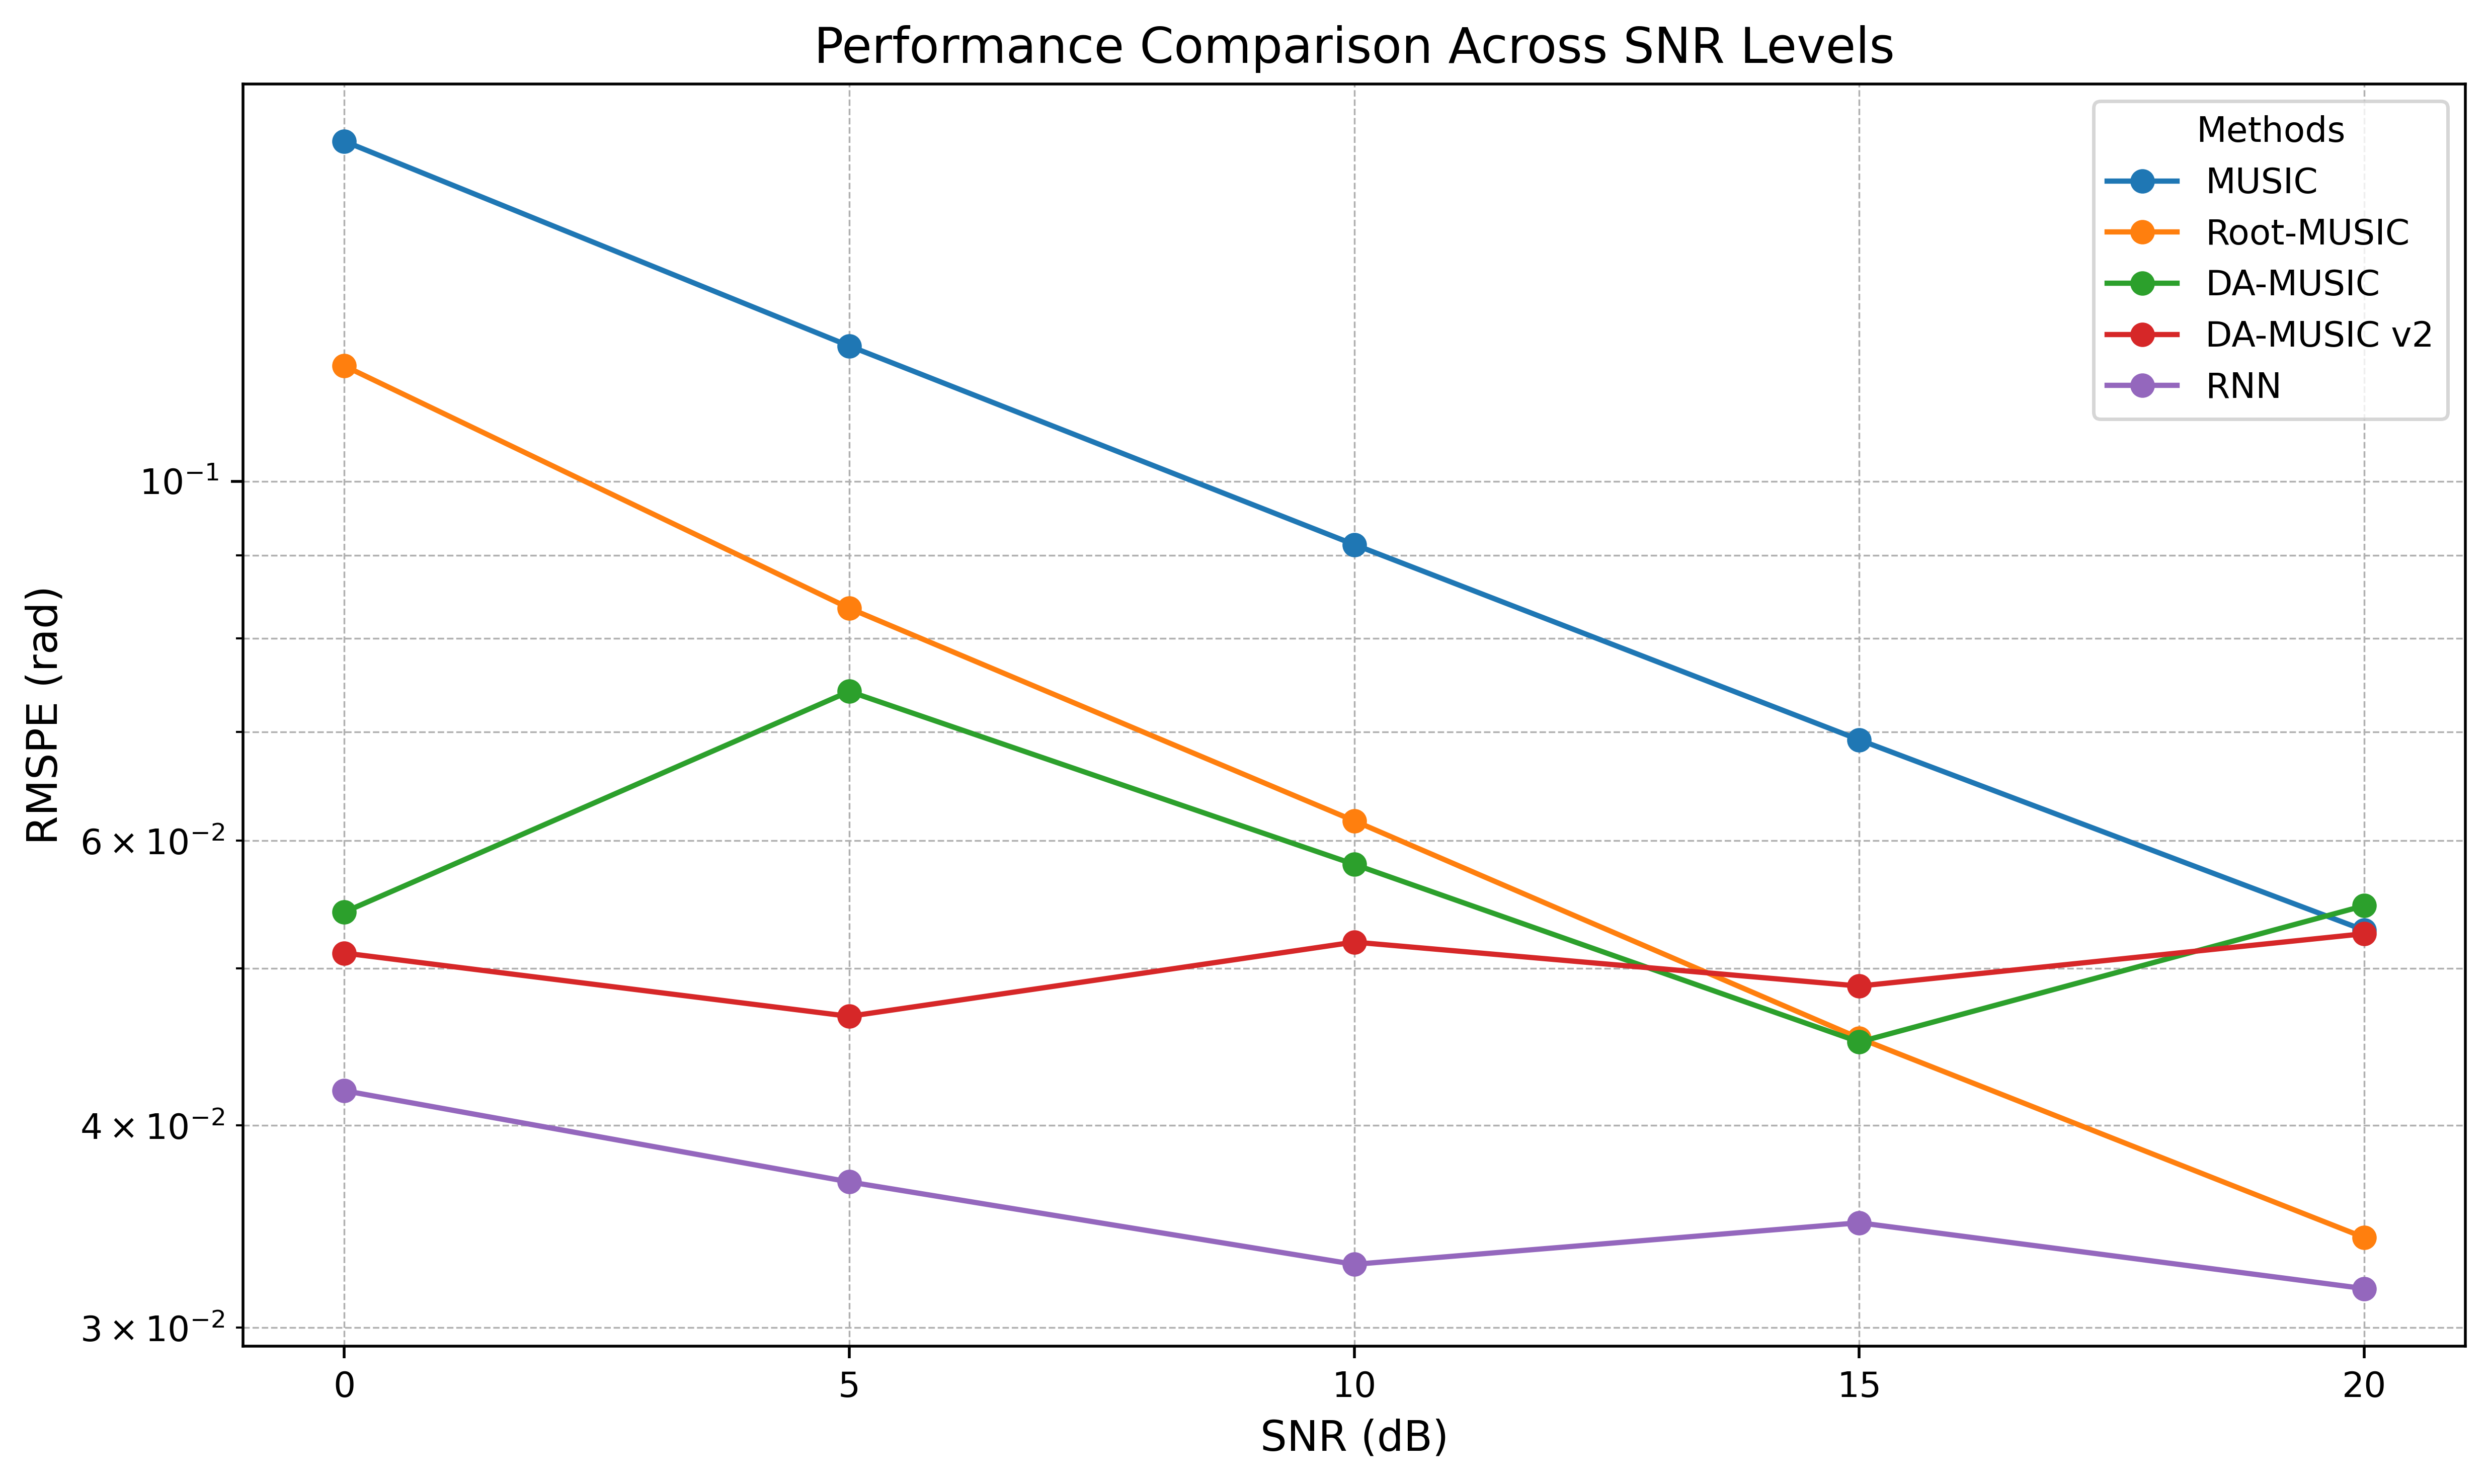

In [5]:
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(SNRs, mean_rmspe[method], marker='o', label=method)

plt.yscale("log")
plt.title("Performance Comparison Across SNR Levels", fontsize=14)
plt.xlabel("SNR (dB)", fontsize=12)
plt.ylabel("RMSPE (rad)", fontsize=12)
plt.xticks(SNRs)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Methods")
plt.tight_layout()
plt.show()

In [6]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20)) 

for i, snr in enumerate(SNRs):
    for j, name in enumerate(all_rmspe):
        axes[j, i].hist(all_rmspe[name][i], bins=100, color='blue', edgecolor='black', alpha=0.7, density=True, range=(0, torch.pi/2))
        axes[j, i].set_xlabel('RMSPE (rad)')
        axes[j, i].set_ylabel('Density')
        axes[j, i].set_title(name + ' at ' + str(snr) + 'dB')

plt.tight_layout()
plt.show()